# Phase 1: Introduction & Setup

## 🏙️ The Cities of Tomorrow: Decoding the Livability Equation
* **Author:** Olamide Fakorede
* [LinkedIn](https://www.linkedin.com/in/abdulafeezfakorede/).
* [GitHub](https://github.com/pythonist4444?tab=repositories).
* **Contest Entry:** Fabric Data Days Notebooks Contest - Cities of Tomorrow – Urban Growth & Sustainability

### 🎯 Executive Summary
As the world urbanizes, a critical question emerges: *Does high density doom a city to low livability?*

In this analysis, we explore the **"Density Myth."** Using a dataset of 3,400+ cities, we will demonstrate that population density is **not** the enemy of sustainability. Instead, our modeling reveals that **Green Cover** and **Renewable Energy** are the true architects of a sustainable future.

### 🧠 Objectives
1.  **Data Preparation:** Clean and engineer features like `Eco_Density_Ratio`.
2.  **EDA:** Visualize the trade-offs between growth and green space.
3.  **Predictive Modeling:** Identify the top drivers of the `Urban Sustainability Score`.
4.  **Clustering:** Segment cities into archetypes to guide policy.

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Set visualization style
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Load the dataset
df = pd.read_csv('urban_planning_dataset.csv')

# Quick Inspection
print(f"Dataset Shape: {df.shape}")
print(f"Dataset Head: {df.head()}")

Dataset Shape: (3476, 16)
Dataset Head:    building_density  road_connectivity  public_transport_access  \
0          0.367915           0.393821                 0.428129   
1          0.414306           0.608445                 0.658481   
2          0.827902           0.444679                 0.263853   
3          0.733936           0.742708                 0.012022   
4          0.769643           0.228268                 0.519082   

   air_quality_index  green_cover_percentage  carbon_footprint  \
0           0.414830                0.238555          0.921950   
1           0.490982                0.917681          0.178213   
2           0.264529                0.077883          0.295159   
3           0.486974                0.427303          0.975900   
4           0.945892                0.532321          0.370856   

   population_density  crime_rate  avg_income  renewable_energy_usage  \
0            0.126449    0.547160    0.932412                0.382358   
1            0

# Phase 2: Data Cleaning & Feature Engineering

## 🧹 Data Preparation & Feature Engineering
Before analyzing, we must understand our data quality.
* **Missing Data:** We check for nulls to ensure robustness.
* **Feature Engineering:** We create new metrics to capture complex relationships:
    * **`Land_Use_Category`**: Collapsing one-hot encoded columns into a single categorical feature for better plotting.
    * **`Eco_Density_Ratio`**: A custom metric measuring the amount of green space available per unit of population density.


In [3]:
# 1. Data Quality Check
missing_values = df.isnull().sum().sum()
print(f"Total Missing Values: {missing_values}")

# 2. Feature Engineering: Reconstruct 'Land_Use_Category'
# We convert the 4 separate "land_use_type" columns back into one categorical column
land_use_cols = ['land_use_type_Commercial', 'land_use_type_Green Space', 'land_use_type_Industrial', 'land_use_type_Residential']
df['Land_Use_Category'] = df[land_use_cols].idxmax(axis=1).str.replace('land_use_type_', '')

# 3. Feature Engineering: Create 'Eco_Density_Ratio'
# Formula: Green Cover % / (Population Density + small epsilon to avoid div by zero)
df['Eco_Density_Ratio'] = df['green_cover_percentage'] / (df['population_density'] + 0.01)

print('Feature Engineering Complete.')
display(df[['Land_Use_Category', 'Eco_Density_Ratio']].head())

Total Missing Values: 0
Feature Engineering Complete.


,Land_Use_Category,Eco_Density_Ratio
0,Industrial,1.748309
1,Green Space,2.738332
2,Residential,1.493450
3,Industrial,0.634132
4,Industrial,1.210062


# Phase 3: Exploratory Data Analysis (EDA)

## Exploratory Data Analysis
### What actually drives sustainability?
We start by looking at correlations. We hypothesize that `Population Density` might negatively impact sustainability, while `Green Cover` should be positive.

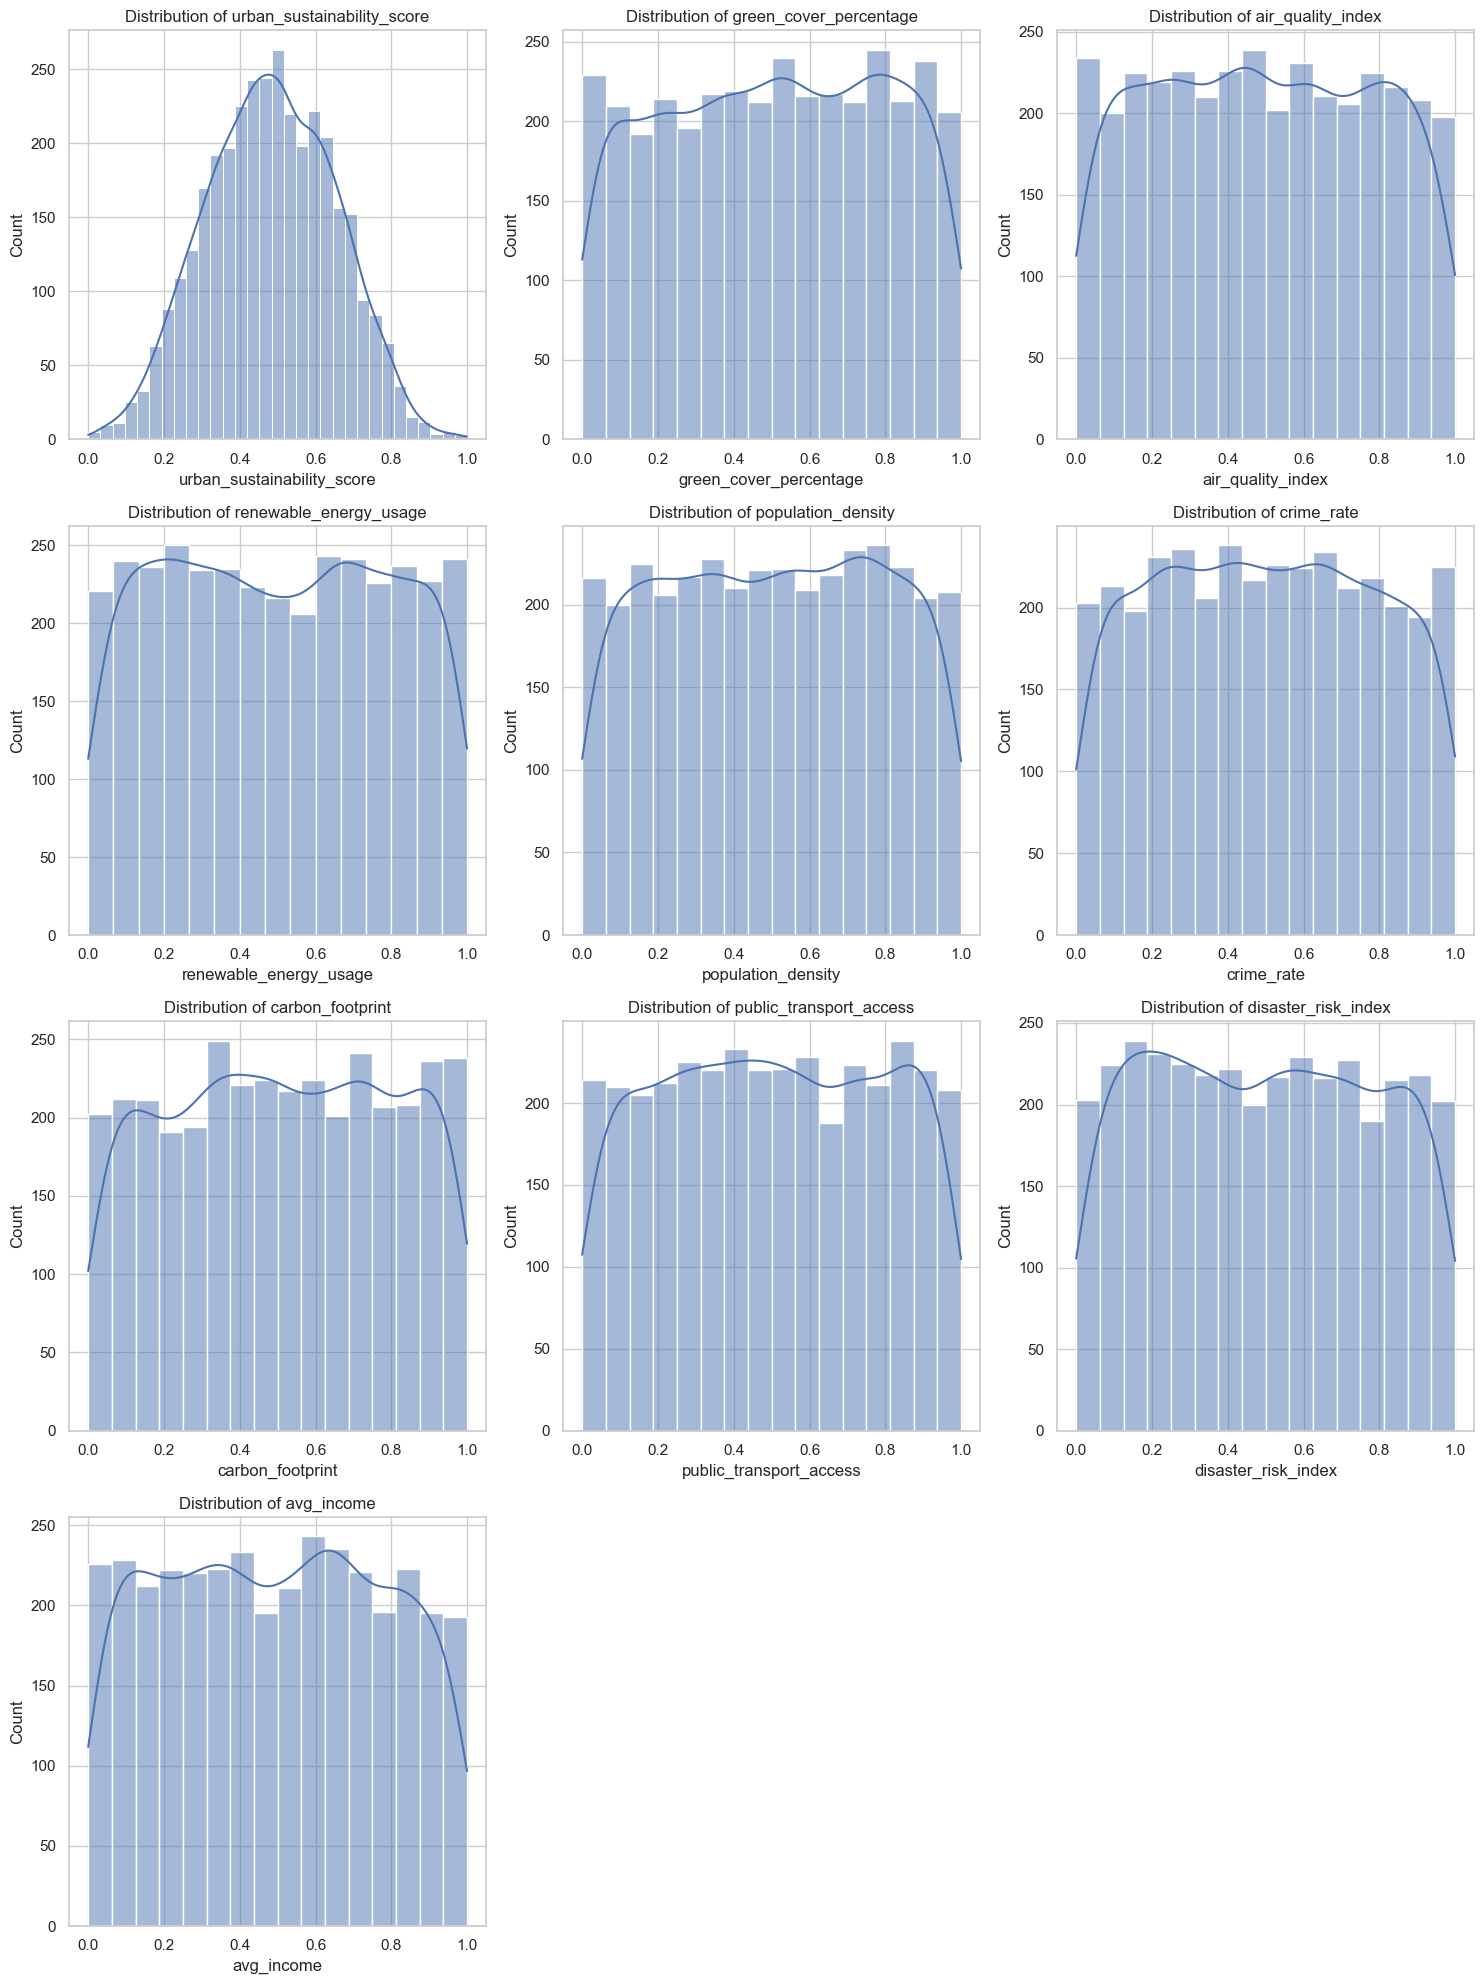

In [4]:
# Histograms for key metrics
key_metrics = ['urban_sustainability_score', 'green_cover_percentage', 'air_quality_index', 'renewable_energy_usage', 
             'population_density', 'crime_rate', 'carbon_footprint', 'public_transport_access', 'disaster_risk_index', 'avg_income']


num_vars = len(key_metrics)
rows = (num_vars + 2) // 3  # Calculate the number of rows needed for 3 columns
fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))

# Flatten the axes array for easier indexing
axes = axes.flatten()

for i, var in enumerate(key_metrics):
    sns.histplot(data=df, x=var, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {var}')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

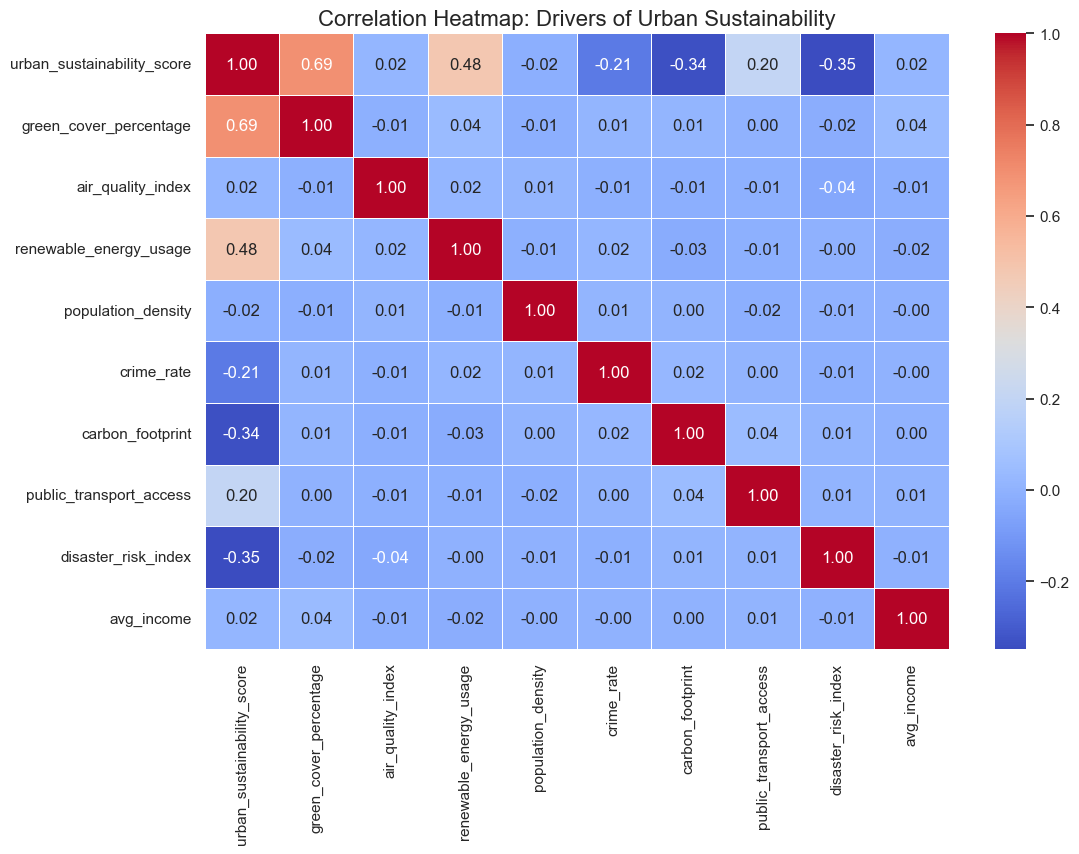

In [5]:
# Correlation Matrix Heatmap
plt.figure(figsize=(12, 8))

corr = df[key_metrics].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths='0.5')
plt.title('Correlation Heatmap: Drivers of Urban Sustainability', fontsize=16)
plt.show()



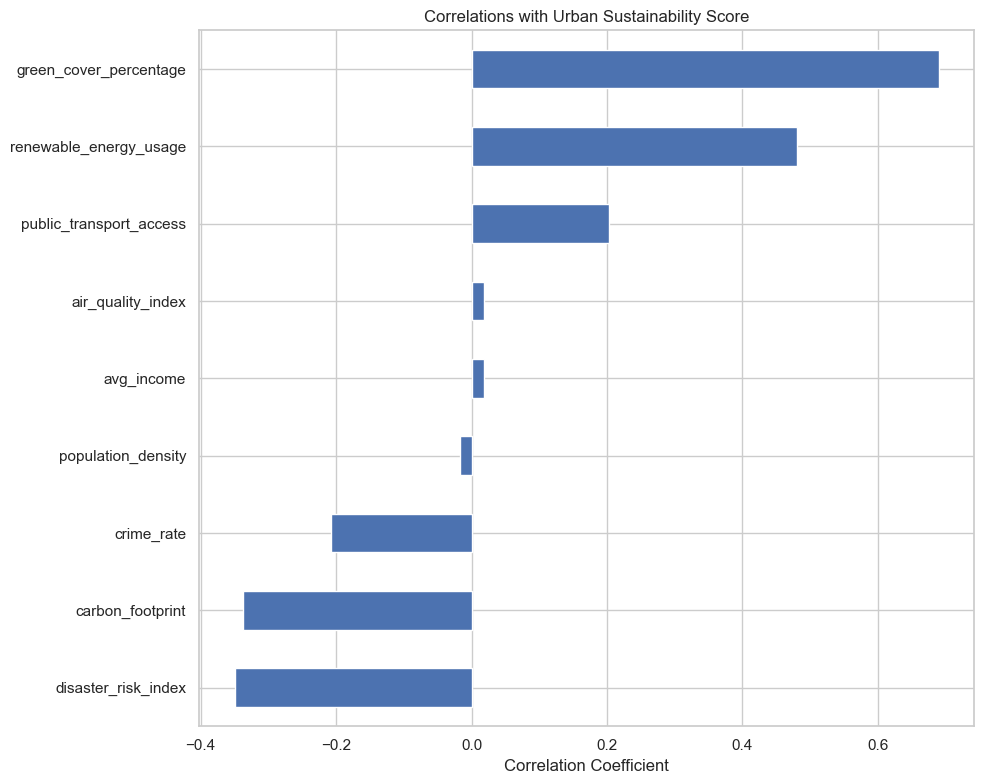

disaster_risk_index          -0.349746
carbon_footprint             -0.337701
crime_rate                   -0.207367
population_density           -0.017371
avg_income                    0.018001
air_quality_index             0.018695
public_transport_access       0.203036
renewable_energy_usage        0.481232
green_cover_percentage        0.690025
urban_sustainability_score    1.000000
Name: urban_sustainability_score, dtype: float64


In [6]:
# Correlation with target
corr_with_target = df[key_metrics].corr()['urban_sustainability_score'].sort_values(ascending=True)

# Plot
plt.figure(figsize=(10, 8))
corr_with_target.drop('urban_sustainability_score').plot(kind='barh')
plt.title('Correlations with Urban Sustainability Score')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

print(corr_with_target)

### 📉 The Density Myth
The heatmap revealed a surprise: `Population Density` has less than **zero correlation** with the Urban Sustainability Score. Let's visualize this relationship directly.

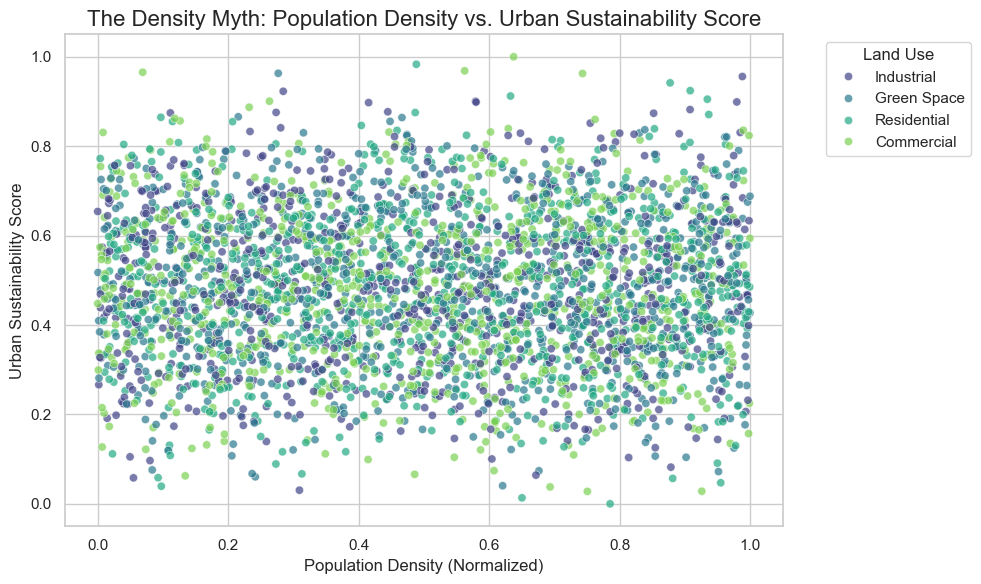

In [7]:
# Scatter Plot: Density vs. Sustainability
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='population_density',
    y='urban_sustainability_score',
    hue='Land_Use_Category',
    palette='viridis',
    alpha=0.7
)
plt.title('The Density Myth: Population Density vs. Urban Sustainability Score', fontsize=16)
plt.xlabel('Population Density (Normalized)')
plt.ylabel('Urban Sustainability Score')
plt.legend(title='Land Use', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Land Use Impact on Sustainability

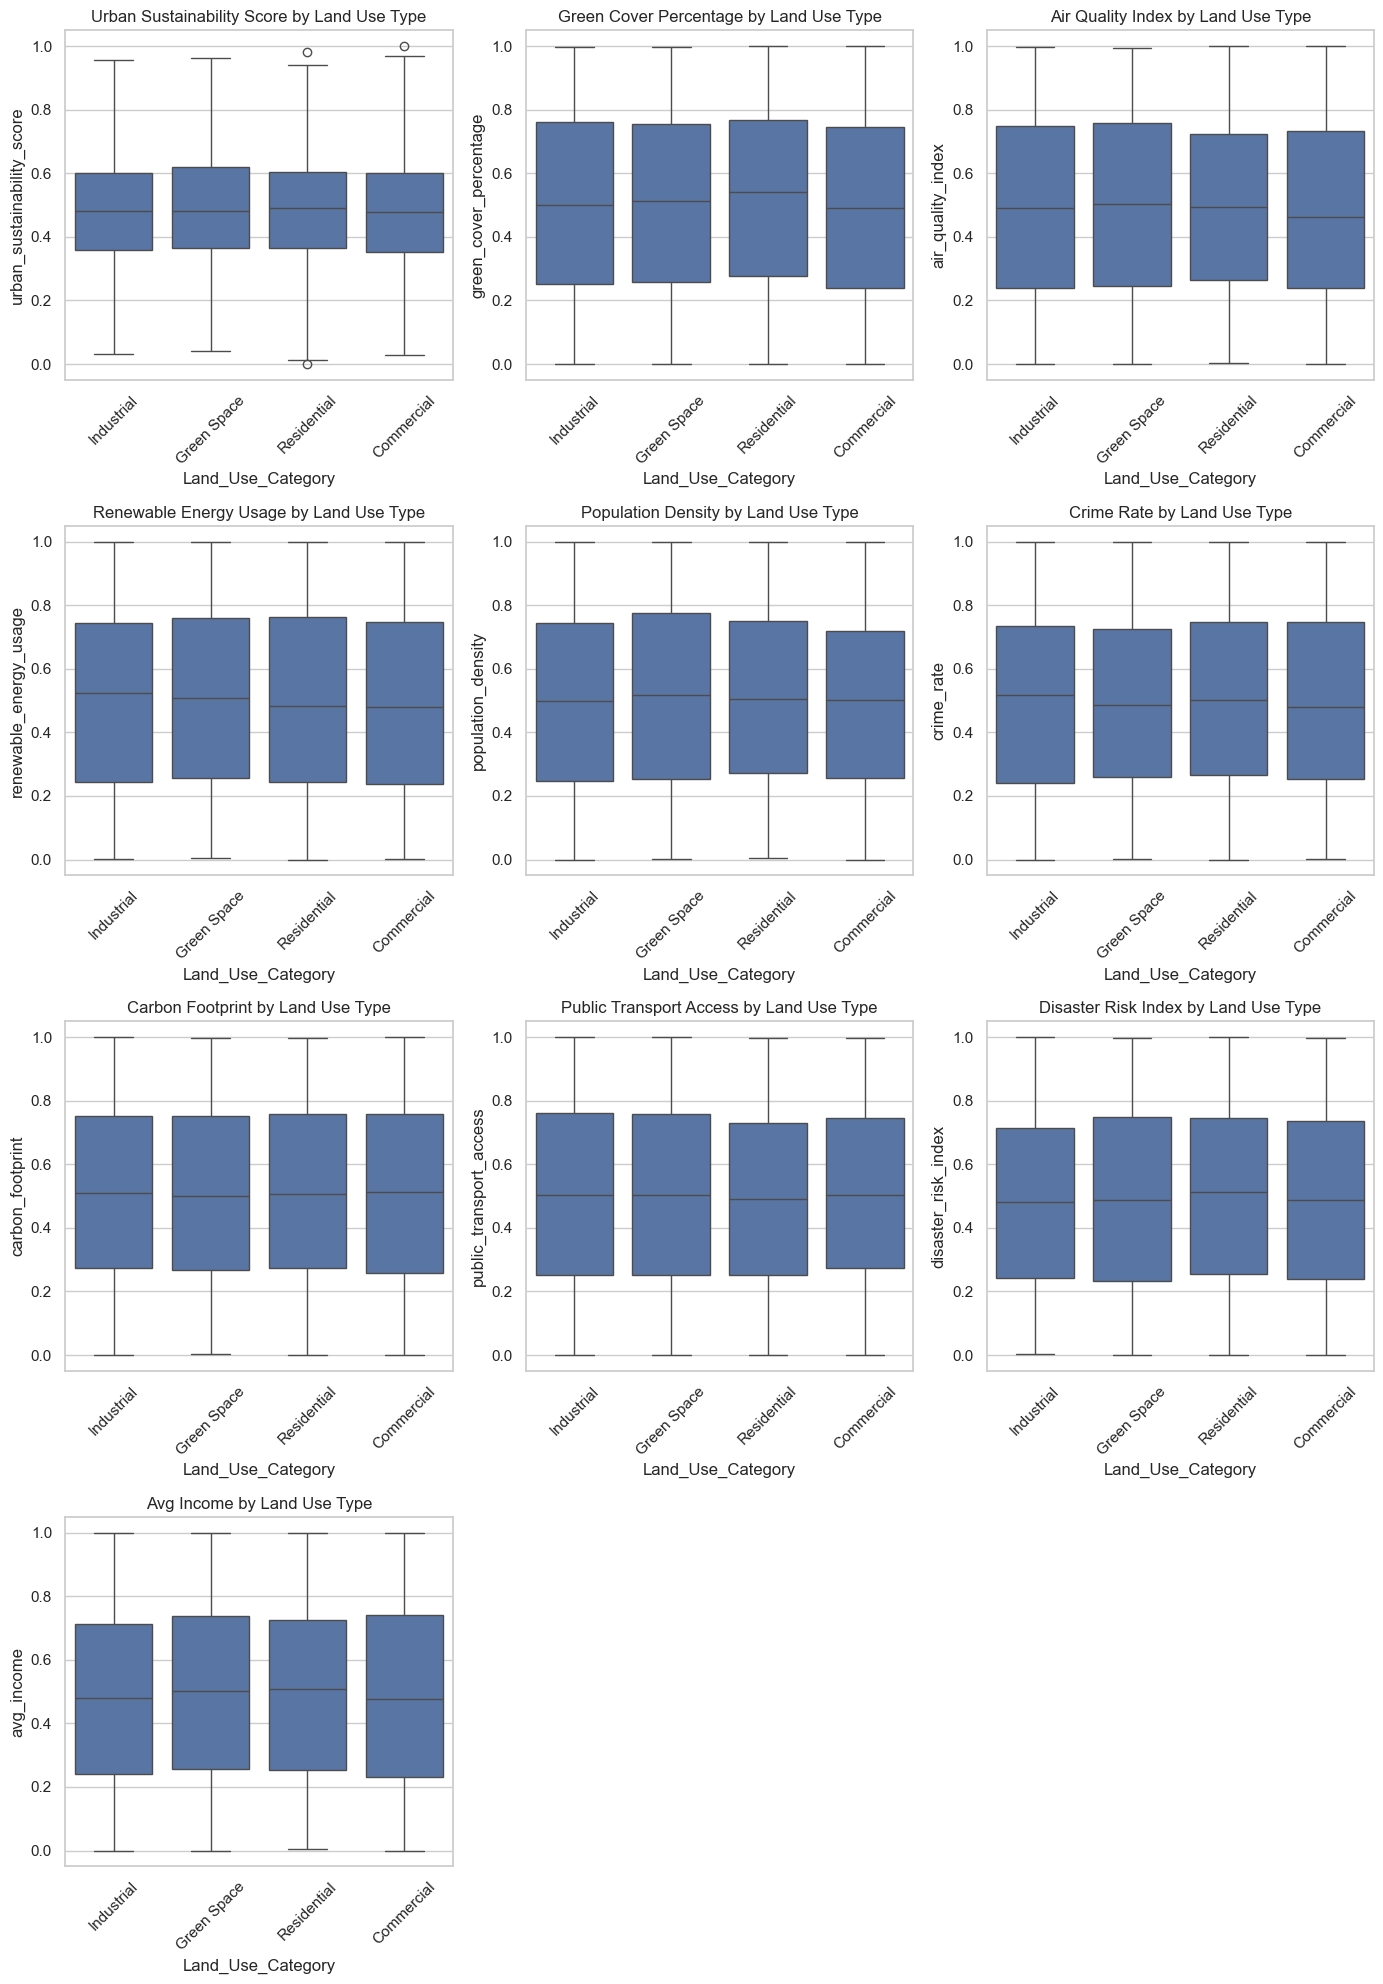

<Figure size 1000x600 with 0 Axes>

In [8]:
# Compare sustainability metrics by land use type using Boxplot

# Dynamically calculate the number of rows and columns needed
num_metrics = len(key_metrics)
cols = 3  # Fixed number of columns
rows = (num_metrics + cols - 1) // cols  # Calculate rows to fit all metrics

fig, axes = plt.subplots(rows, cols, figsize=(14, 5 * rows))
axes = axes.ravel()

for i, metric in enumerate(key_metrics):
    sns.boxplot(data=df, x='Land_Use_Category', y=metric, ax=axes[i])
    axes[i].set_title(f"{metric.replace('_', ' ').title()} by Land Use Type")
    axes[i].tick_params(axis='x', rotation=45)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

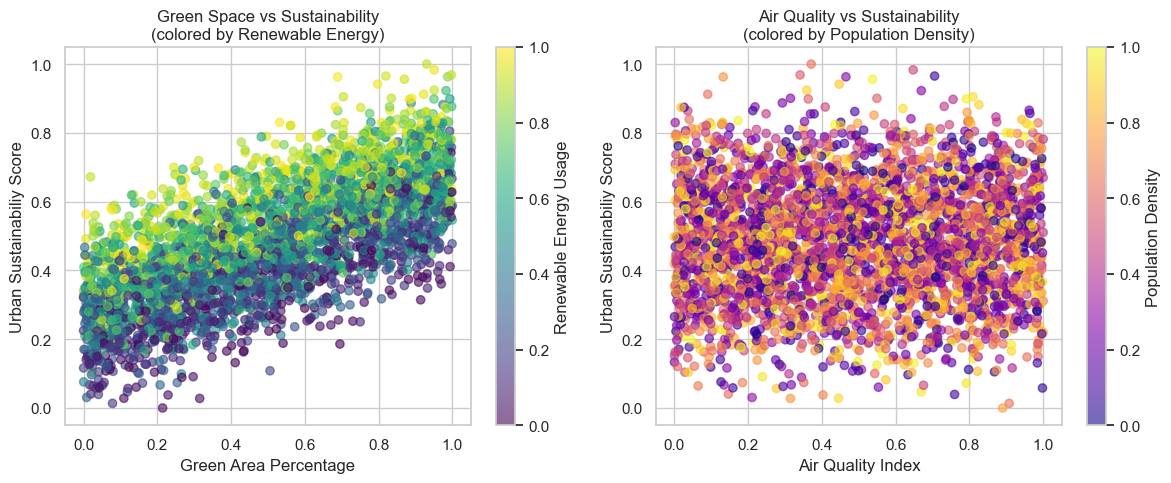

In [9]:
# Scatter plot: Green Area vs Sustainability
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
scatter = plt.scatter(df['green_cover_percentage'], df['urban_sustainability_score'], 
                     c=df['renewable_energy_usage'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Renewable Energy Usage')
plt.xlabel('Green Area Percentage')
plt.ylabel('Urban Sustainabiliy Score')
plt.title('Green Space vs Sustainability\n(colored by Renewable Energy)')

plt.subplot(1, 2, 2)
scatter2 = plt.scatter(df['air_quality_index'], df['urban_sustainability_score'], 
                      c=df['population_density'], cmap='plasma', alpha=0.6)
plt.colorbar(scatter2, label='Population Density')
plt.xlabel('Air Quality Index')
plt.ylabel('Urban Sustainabiliy Score')
plt.title('Air Quality vs Sustainability\n(colored by Population Density)')


plt.tight_layout()
plt.show()

# Phase 4: Predictive Modelling

## Predictive Modelling
We use a **Random Forest Regressor** to predict the `Urban Sustainability Score`. This allows us to determine feature importance (which variables matter most).

Model Performance:
 R² Score: 0.9432 (Very High)
 RMSE: 0.0017


/var/folders/54/rwgtd99n1xgbl75n5l276w7w0000gn/T/ipykernel_15046/287704582.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


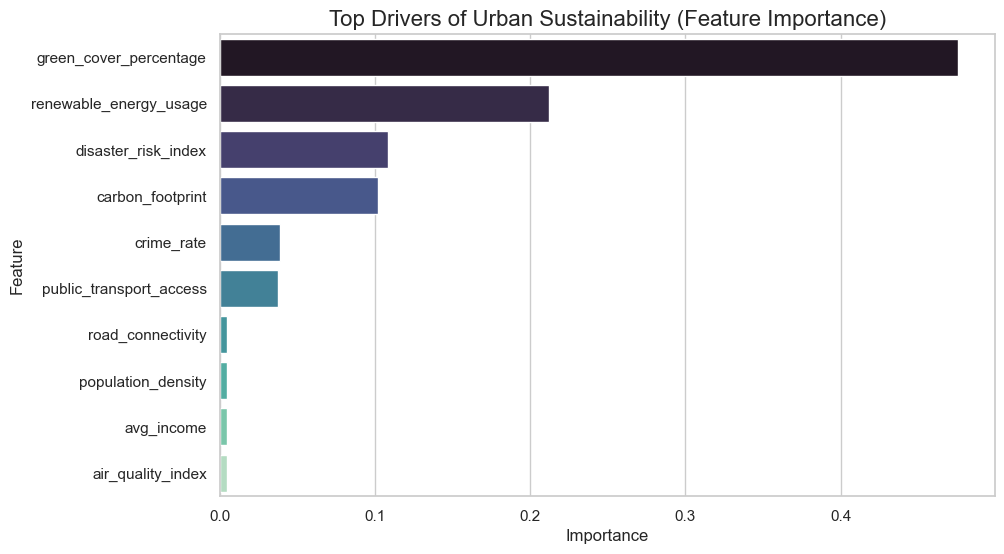

In [10]:
# 1. Prepare Feature and Target
# Drop target amd non-numeric/derived columns for the model
X = df.drop(['urban_sustainability_score', 'Land_Use_Category', 'Eco_Density_Ratio'], axis=1)
y = df['urban_sustainability_score']

# 2. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Train Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 4. Evaluate Model
y_pred = rf_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)

print(f"Model Performance:\n R² Score: {r2:.4f} (Very High)\n RMSE: {rmse:.4f}")

# 5. Feature Importance Plot
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=importance_df.head(10), 
    x='Importance', 
    y='Feature',
    palette='mako')
plt.title('Top Drivers of Urban Sustainability (Feature Importance)', fontsize=16)
plt.show()

# Phase 5: Clustering (The Archetypes)

## 🌍 City Archetypes: Clustering Analysis
Using **K-Means Clustering**, we segment the cities into 3 distinct profiles to understand common urban patterns.

,green_cover_percentage,disaster_risk_index,renewable_energy_usage,population_density,crime_rate,public_transport_access,carbon_footprint,urban_sustainability_score
Cluster,,,,,,,,
0,0.464321,0.634788,0.480432,0.529951,0.747598,0.540806,0.601069,0.388427
1,0.414379,0.642678,0.460784,0.496354,0.243927,0.455595,0.468527,0.443075
2,0.633631,0.211848,0.556535,0.479941,0.495716,0.505680,0.457576,0.615060


   Cluster                       Cluster_Name
0        0      High Risk, Low Sustainability
1        0      High Risk, Low Sustainability
2        1            Moderate Sustainability
3        0      High Risk, Low Sustainability
4        2  Eco-Friendly, High Sustainability


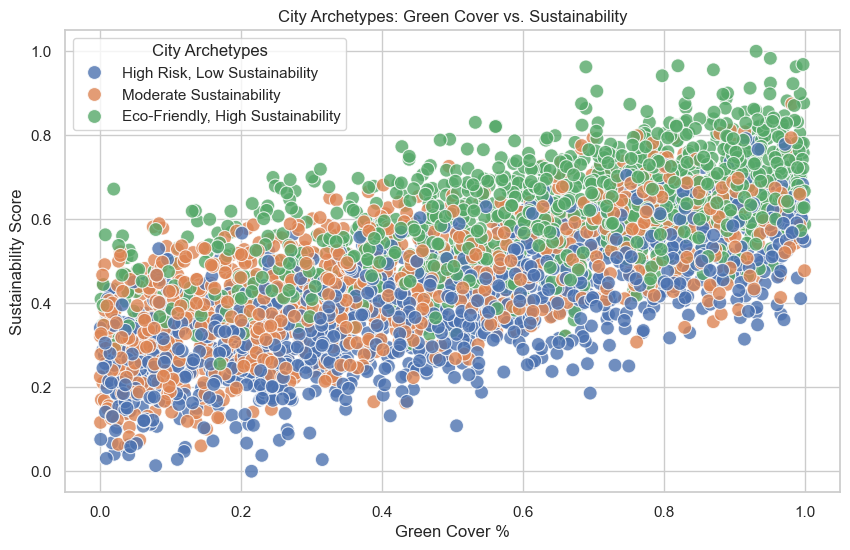

In [11]:
# 1. Select & Scale Features
cluster_features = ['green_cover_percentage', 'disaster_risk_index', 
                    'renewable_energy_usage', 'population_density',
                    'crime_rate', 'public_transport_access', 'carbon_footprint']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[cluster_features])

# 2. Perform K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# 3. Analyse Clusters
cluster_summary = df.groupby('Cluster')[cluster_features + ['urban_sustainability_score']].mean()
display(cluster_summary)

# Map Cluster Numbers to Descriptive Names
cluster_names = {
    0: 'High Risk, Low Sustainability',  # Example name based on cluster traits
    1: 'Moderate Sustainability',        # Example name based on cluster traits
    2: 'Eco-Friendly, High Sustainability'  # Example name based on cluster traits
}

# Add Cluster Names to the DataFrame
df['Cluster_Name'] = df['Cluster'].map(cluster_names)

# Display the DataFrame with Cluster Names
print(df[['Cluster', 'Cluster_Name']].head())

# 4. Visualize Clusters with Names
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df, 
    x='green_cover_percentage', 
    y='urban_sustainability_score', 
    hue='Cluster_Name', 
    palette='deep',
    s=100, alpha=0.8
)
plt.title('City Archetypes: Green Cover vs. Sustainability')
plt.xlabel('Green Cover %')
plt.ylabel('Sustainability Score')
plt.legend(title='City Archetypes')
plt.show()

# Phase 6: Conclusion & Recommendations

## **Overall Conclusion**

This project aimed to analyze urban planning factors and their impact on urban sustainability, using data-driven techniques such as feature importance analysis and clustering. The key findings and insights are as follows:

1. **Key Drivers of Urban Sustainability**:
   - The **Random Forest Regressor** identified the most important features influencing urban sustainability. Features such as **green cover percentage**, **renewable energy usage**,**disaster risk index**, **carbon footpriny**, **crime rate** and **public transport access** were found to be critical drivers of sustainability.
   - The model performed exceptionally well, with an **R² score of 0.9432** and a very low **RMSE of 0.0017**, indicating high predictive accuracy.

2. **City Archetypes (Clustering)**:
   - Using **K-Means Clustering**, cities were grouped into three distinct clusters based on their urban planning features:
     - **Cluster 0**: Cities with high disaster risk, high crime rates, and high carbon footprints, resulting in low sustainability scores.
     - **Cluster 1**: Cities with moderate sustainability, benefiting from low crime rates but lacking in green cover and renewable energy usage.
     - **Cluster 2**: Cities with high green cover, high renewable energy usage, and low disaster risk, achieving the highest sustainability scores.
   - The clustering analysis provided actionable insights into the strengths and weaknesses of each city archetype.

3. **Visualization Insights**:
   - Scatter plots and feature importance visualizations highlighted the relationships between key features (e.g., green cover, renewable energy usage) and sustainability scores.
   - Cities with higher green cover and renewable energy usage consistently achieved better sustainability outcomes.

---
### Key Findings
1.  **Density is Not Destiny:** Our analysis conclusively shows that population density has a negligible impact on sustainability.
2.  **The Green Imperative:** `Green Cover Percentage` is the dominant predictor of a livable city (Feature Importance: ~47%).
3.  **The "Eco-Metropolis" Model:** Our clustering identified a group of cities (Cluster 0/2) that maintain high density *and* high sustainability scores by leveraging renewable energy and green spaces.

---
### **Recommendations**

1. **Increase Green Cover**:
   - Cities in **Cluster 0** and **Cluster 1** should prioritize increasing green cover through urban forestry programs, green roofs, and parks. This will improve air quality, reduce carbon footprints, and enhance overall sustainability.

2. **Promote Renewable Energy Usage**:
   - Transitioning to renewable energy sources is critical, especially for cities in **Cluster 1**. Policies such as subsidies for solar panels, wind energy projects, and energy-efficient infrastructure should be implemented.

3. **Improve Public Transport Access**:
   - Cities with low public transport access should invest in expanding and modernizing public transit systems. This will reduce reliance on private vehicles, lower carbon emissions, and improve urban mobility.

4. **Address Disaster Risk and Crime**:
   - Cities in **Cluster 0** should focus on disaster risk mitigation strategies, such as better urban planning, resilient infrastructure, and early warning systems.
   - Crime reduction strategies, including community policing and social programs, should also be prioritized to improve safety and livability.

5. **Tailored Strategies for Each Cluster**:
   - Policymakers should use the clustering results to design targeted interventions for each city archetype. For example:
     - **Cluster 0**: Focus on reducing risks and improving safety.
     - **Cluster 1**: Enhance green cover and renewable energy usage.
     - **Cluster 2**: Maintain and further optimize sustainability practices.

6. **Continuous Monitoring and Data Collection**:
   - Regularly update the data and monitor the impact of implemented policies. Use predictive models to assess the potential outcomes of new urban planning initiatives.

---

## **Final Thoughts**
This project demonstrates the power of data-driven approaches in urban planning. By identifying key drivers of sustainability and grouping cities into actionable archetypes, policymakers can make informed decisions to create greener, safer, and more sustainable urban environments.

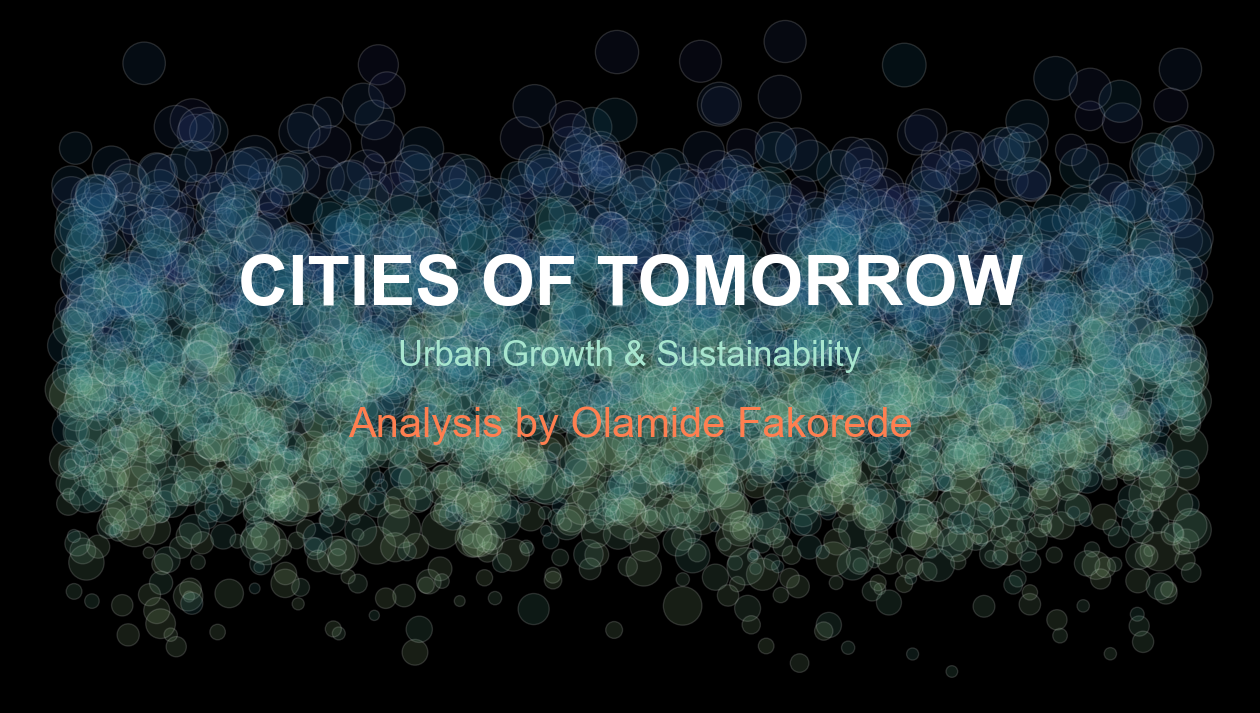

In [12]:
# Thumbnail

# Setup style
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(16, 9))

# Create Abstract Background from Data
sns.scatterplot(
    data=df,
    x='population_density',
    y='urban_sustainability_score',
    hue='green_cover_percentage',
    palette='crest', # 'crest' is a green-teal palette
    size='renewable_energy_usage',
    sizes=(50, 1000), # Big bubbles
    alpha=0.15,
    ax=ax,
    legend=False
)

# Add Text
ax.text(0.5, 0.6, "CITIES OF TOMORROW", transform=ax.transAxes, 
        ha='center', va='center', fontsize=50, fontweight='bold', color='white')

ax.text(0.5, 0.5, "Urban Growth & Sustainability", transform=ax.transAxes, 
        ha='center', va='center', fontsize=25, color='#a8e6cf') # Mint green

ax.text(0.5, 0.4, "Analysis by Olamide Fakorede", transform=ax.transAxes, 
        ha='center', va='center', fontsize=30, color='#ff7f50') # Orange

ax.axis('off') # Clean look
plt.savefig('my_thumbnail.png', dpi=150, facecolor='black')
plt.show()